# Diagram

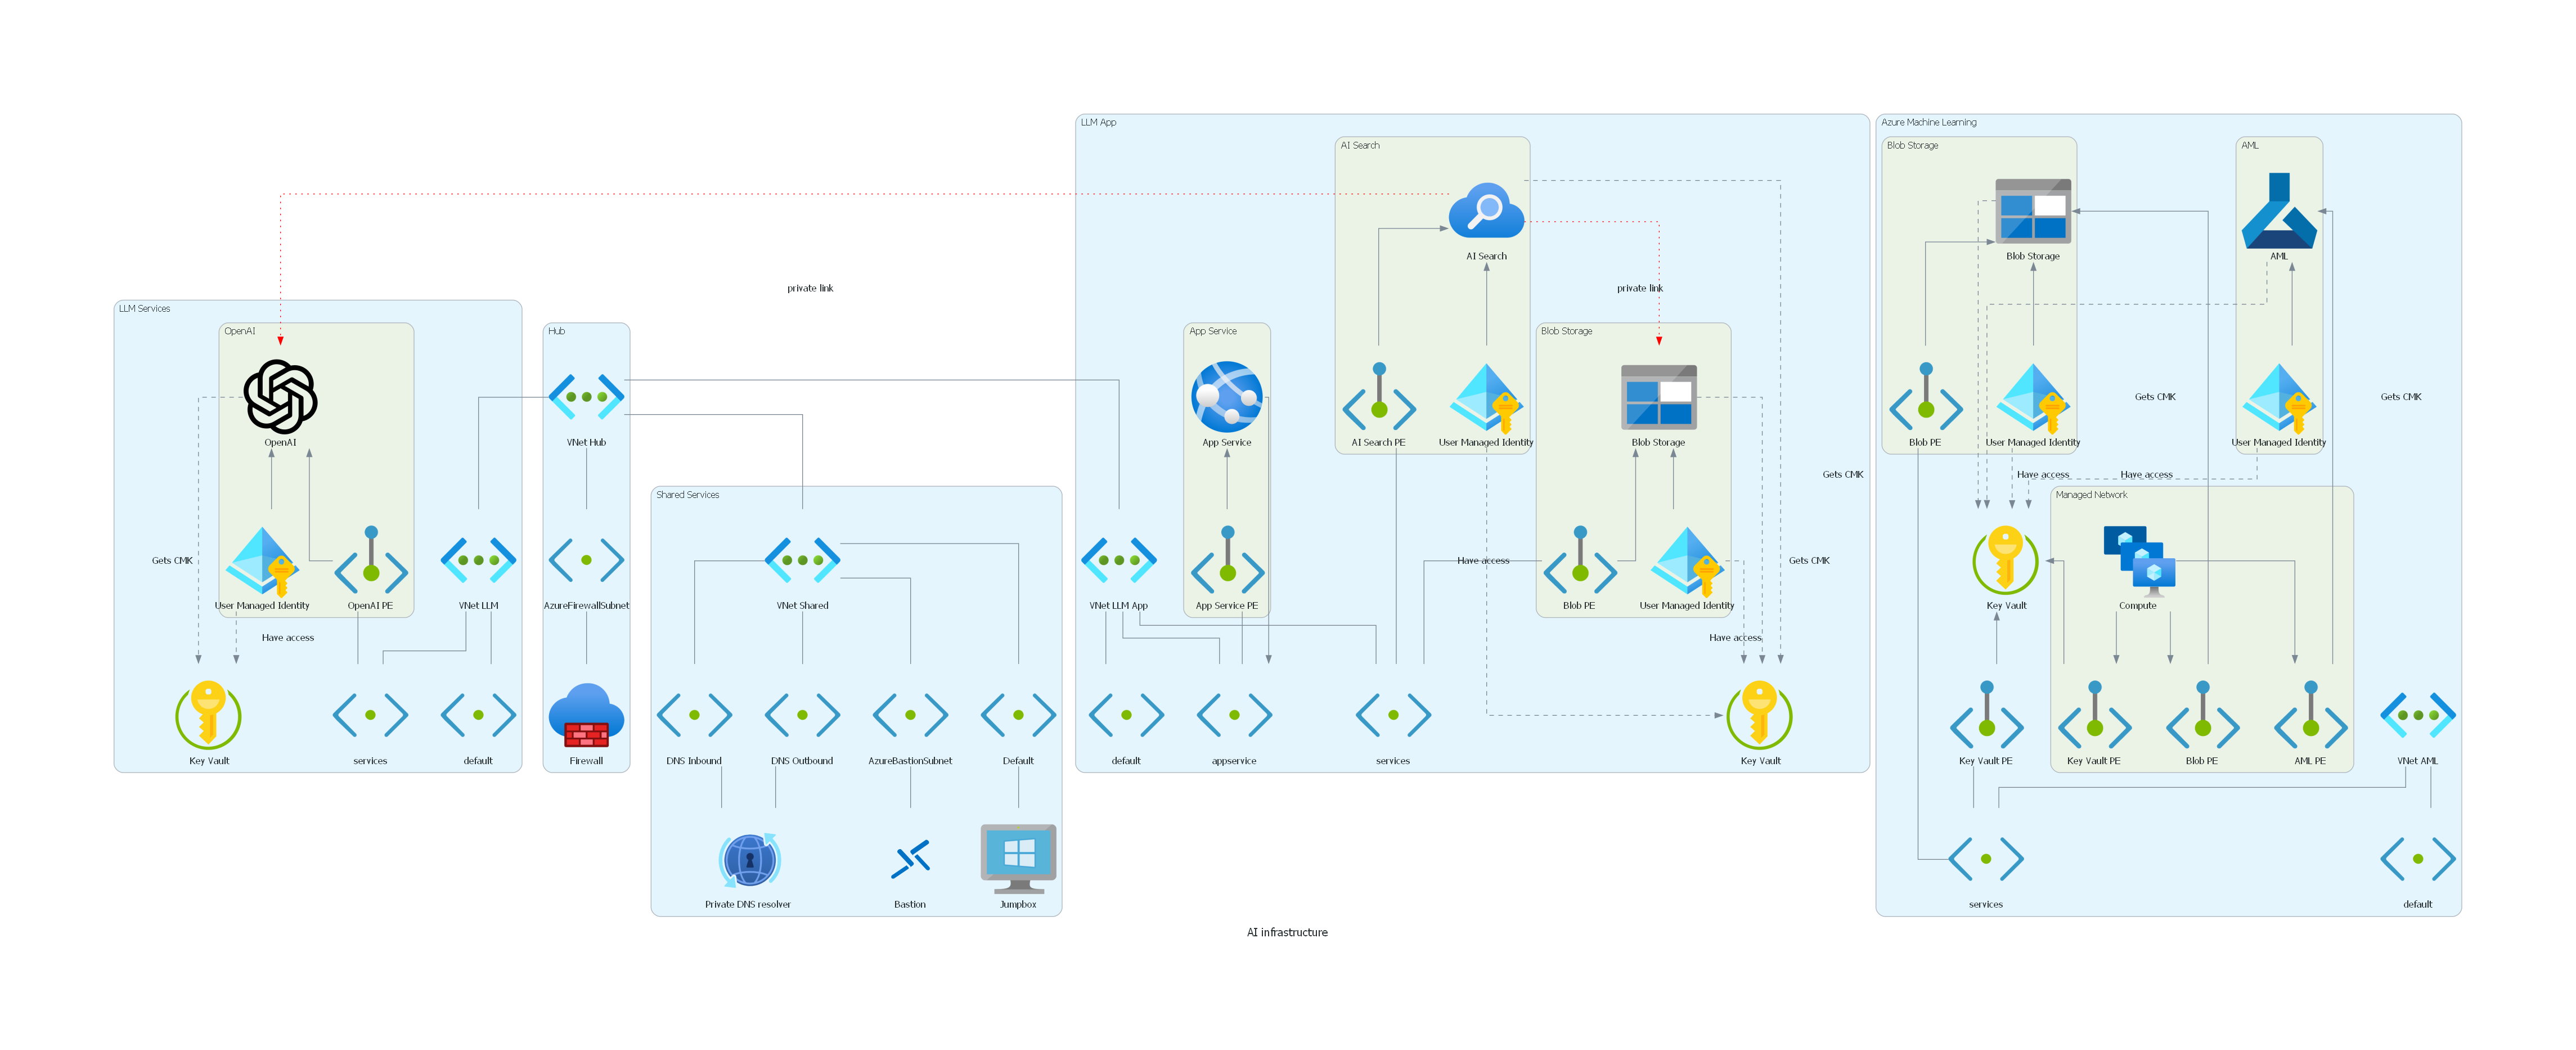

In [110]:
from diagrams import Cluster, Diagram, Edge
from diagrams.azure.network import Firewall, VirtualNetworks, Subnets
from diagrams.azure.compute import VMWindows, VMScaleSet
from diagrams.azure.security import KeyVaults
from diagrams.azure.identity import ManagedIdentities
from diagrams.azure.web import AppServices, Search
from diagrams.azure.database import BlobStorage
from diagrams.azure.ml import MachineLearningServiceWorkspaces
from diagrams.custom import Custom

with Diagram("AI infrastructure", show=False, direction="TB") as diag:
    # Hub subscription
    with Cluster("Hub"):
        # Networking
        vnet_hub = VirtualNetworks("VNet Hub")
        sub_hub_fw = Subnets("AzureFirewallSubnet")
        vnet_hub - sub_hub_fw

        # Components
        fw = Firewall("Firewall")
        sub_hub_fw - fw

    # Shared services subscription
    with Cluster("Shared Services"):
        vnet_shared = VirtualNetworks("VNet Shared")
        sub_shared_dns_in = Subnets("DNS Inbound")
        sub_shared_dns_out = Subnets("DNS Outbound")
        sub_shared_default = Subnets("Default")
        sub_shared_bastion = Subnets("AzureBastionSubnet")
        resolver = Custom("Private DNS resolver", "./icons/private_dns_resolver.png")
        jump = VMWindows("Jumpbox")
        bastion = Custom("Bastion", "./icons/bastion.png")
        vnet_shared - sub_shared_dns_in
        vnet_shared - sub_shared_dns_out
        vnet_shared - sub_shared_default
        vnet_shared - sub_shared_bastion
        sub_shared_dns_in - resolver
        sub_shared_dns_out - resolver
        sub_shared_default - jump
        sub_shared_bastion - bastion

    # LLM services subscription
    with Cluster("LLM Services"):
        # Networking
        vnet_llm = VirtualNetworks("VNet LLM")
        sub_llm_default = Subnets("default")
        sub_llm_services = Subnets("services")
        vnet_llm - sub_llm_default
        vnet_llm - sub_llm_services

        # Components
        with Cluster("OpenAI"):
            openai = Custom("OpenAI", "./icons/openai.png")
            pe_openai = Custom("OpenAI PE", "./icons/private_endpoint.png")
            openai_umi = ManagedIdentities("User Managed Identity")

        openai_kv = KeyVaults("Key Vault")
        
        # Connections
        openai << pe_openai
        pe_openai - sub_llm_services
        openai >> Edge(style="dashed", label="Gets CMK") >>openai_kv
        openai << openai_umi
        openai_umi >> Edge(style="dashed", label="Have access") >> openai_kv

    # LLM App subscription
    with Cluster("LLM App"):
        # Networking
        vnet_llmapp = VirtualNetworks("VNet LLM App")
        sub_llmapp_default = Subnets("default")
        sub_llmapp_services = Subnets("services")
        sub_llmapp_appservice = Subnets("appservice")
        vnet_llmapp - sub_llmapp_default
        vnet_llmapp - sub_llmapp_services
        vnet_llmapp - sub_llmapp_appservice
        
        # Components
        llmapp_kv = KeyVaults("Key Vault")

        with Cluster("App Service"):
            appservice = AppServices("App Service")
            pe_appservice = Custom("App Service PE", "./icons/private_endpoint.png")

        with Cluster("AI Search"):
            search = Search("AI Search")
            pe_search = Custom("AI Search PE", "./icons/private_endpoint.png")
            search_umi = ManagedIdentities("User Managed Identity")

        with Cluster("Blob Storage"):
            blob = BlobStorage("Blob Storage")
            pe_blob = Custom("Blob PE", "./icons/private_endpoint.png")
            blob_umi = ManagedIdentities("User Managed Identity")

        # Connections
        appservice << pe_appservice
        pe_appservice - sub_llmapp_appservice
        appservice >> sub_llmapp_appservice
        search << pe_search
        blob << pe_blob
        pe_search - sub_llmapp_services
        pe_blob - sub_llmapp_services

        blob >> Edge(style="dashed", label="Gets CMK") >> llmapp_kv
        blob << blob_umi
        blob_umi >> Edge(style="dashed", label="Have access") >> llmapp_kv

        search >> Edge(style="dashed", label="Gets CMK") >> llmapp_kv
        search << search_umi
        search_umi >> Edge(style="dashed", label="Have access") >> llmapp_kv

    # Azure Machine Learning
    with Cluster("Azure Machine Learning"):
        # Networking
        vnet_aml = VirtualNetworks("VNet AML")
        sub_aml_default = Subnets("default")
        sub_aml_services = Subnets("services")
        vnet_aml - sub_aml_default
        vnet_aml - sub_aml_services

        # Components
        with Cluster("AML"):
            aml_workspace = MachineLearningServiceWorkspaces("AML")
            aml_umi = ManagedIdentities("User Managed Identity")

        with Cluster("Blob Storage"):
            aml_blob = BlobStorage("Blob Storage")
            aml_blob_umi = ManagedIdentities("User Managed Identity")
            pe_aml_blob = Custom("Blob PE", "./icons/private_endpoint.png")

        aml_kv = KeyVaults("Key Vault")
        pe_aml_kv = Custom("Key Vault PE", "./icons/private_endpoint.png")

        # Microsoft Managed Network
        with Cluster("Managed Network"):
            aml_compute = VMScaleSet("Compute")
            aml_managed_pe_workspace = Custom("AML PE", "./icons/private_endpoint.png")
            aml_managed_pe_blob = Custom("Blob PE", "./icons/private_endpoint.png")
            aml_managed_pe_kv = Custom("Key Vault PE", "./icons/private_endpoint.png")

        # Connections
        aml_workspace >> Edge(style="dashed", label="Gets CMK") >> aml_kv
        aml_workspace << aml_umi
        aml_umi >> Edge(style="dashed", label="Have access") >> aml_kv

        aml_blob >> Edge(style="dashed", label="Gets CMK") >> aml_kv
        aml_blob << aml_blob_umi
        aml_blob_umi >> Edge(style="dashed", label="Have access") >> aml_kv


        aml_blob << pe_aml_blob
        pe_aml_blob - sub_aml_services
        aml_kv << pe_aml_kv
        pe_aml_kv - sub_aml_services
        aml_blob << aml_managed_pe_blob
        aml_kv << aml_managed_pe_kv
        aml_workspace << aml_managed_pe_workspace
        aml_compute >> aml_managed_pe_workspace
        aml_compute >> aml_managed_pe_blob
        aml_compute >> aml_managed_pe_kv

    # Connections
    vnet_hub - vnet_shared
    vnet_hub - vnet_llm
    vnet_hub - vnet_llmapp

    search >> Edge(label="private link", color="red", style="dotted") >> blob
    search >> Edge(label="private link", color="red", style="dotted") >> openai
diag